# Window Feature Classification Model: ANN with Feature Engineering

This file is composed of an artifical neural network classification model to evaluate if using features from windows of time (20 seconds with 10 second overlap), would generate a better model than our simple timepoint classifier. Leave-One-Person-Out (LOPO) Cross-Validation is used to validate the model. 

__INPUT: .csv files containing the rolled sensor data with feature engineering (engineered_features.csv)__

__OUTPUT: Neural Network Multi-Classification Window Featuer Model (F1 Score = 0.871)__

## Imports

In [244]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import tensorflow as tf

## Read in Data

The loaded dataset contains windows of data that are 20 seconds long with a 10 second overlap. These are stored as arrays in the dataframe.

In [245]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/Users/N1/Data7/Data-2020/10_code/40_usable_data_for_models/41_Duke_Data/engineered_features.csv')

We add a window number that changes everytime there is a new activity present, as we wish to use this as a feature.

In [246]:
df = df.assign(count=df.groupby(df.Activity.ne(df.Activity.shift()).cumsum()).cumcount().add(1))

In [247]:
df.head(5)
#what the sensor names correspond to
#['ACC1', 'ACC2', 'ACC3','TEMP', 'EDA', 'HR', 'BVP', 'Magnitude',] 
#Accelerometry Axes, Body Temperature, Electrodermal Activity, Heart Rate, Blood Volume Pulse, Magnitude of Axes

,ACC1,ACC2,ACC3,TEMP,EDA,BVP,HR,Magnitude,Subject_ID,Activity,Round,ACC1_mean,ACC2_mean,ACC3_mean,TEMP_mean,EDA_mean,BVP_mean,HR_mean,Magnitude_mean,ACC1_std,ACC2_std,ACC3_std,TEMP_std,EDA_std,BVP_std,HR_std,Magnitude_std,ACC1_skew,ACC2_skew,ACC3_skew,TEMP_skew,EDA_skew,BVP_skew,HR_skew,Magnitude_skew,ACC1_min,ACC2_min,ACC3_min,TEMP_min,EDA_min,BVP_min,HR_min,Magnitude_min,ACC1_max,ACC2_max,ACC3_max,TEMP_max,EDA_max,BVP_max,HR_max,Magnitude_max,count
0,[41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 ...,[27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.0 ...,[40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0 ...,[32.39 32.39 32.39 32.39 32.34 32.34 32.34 32....,[0.275354 0.276634 0.270231 0.270231 0.26895 0...,[15.25 -12.75 -42.99 18.39 13.61 -9.66 -35.47 ...,[78.98 78.83500000000002 78.69 78.545 78.4 78....,[63.410093833710725 63.453053512025726 63.4961...,19-001,Baseline,1,40.248370,28.012880,38.824457,32.350,0.262354,-0.109875,73.931187,62.553853,0.701573,0.687590,0.632616,0.017607,0.004877,18.439453,2.574676,0.609756,-0.082592,-0.558848,0.705668,0.714533,0.896382,-0.392823,0.296262,0.531557,39.0,26.456522,38.0,32.33,0.254862,-42.99,69.7650,61.692787,41.543478,29.0,40.0,32.39,0.276634,34.83,78.98,63.757353,1
1,[39.0 39.06521739130435 39.130434782608695 39....,[29.0 28.93478260869565 28.869565217391305 28....,[38.0 38.02173913043478 38.04347826086956 38.0...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.25998499999999997 0.25998499999999997 0.258...,[-18.83 -0.3 11.03 6.09 -15.3 14.61 6.75 -2.38...,[73.52 73.435 73.35 73.265 73.18 73.0925 73.00...,[61.69278726074872 61.7168170027034 61.7409828...,19-001,Baseline,1,40.820000,26.815000,38.192500,32.339,0.261058,0.321375,69.481750,62.021872,1.192214,1.149559,0.529382,0.012610,0.003007,20.104717,2.608254,0.542348,0.515544,0.109446,-0.188071,0.787066,0.212943,-0.322900,-0.170923,-0.438037,39.0,24.600000,37.2,32.31,0.254862,-48.52,64.8025,60.778286,43.800000,29.0,39.0,32.37,0.266389,37.72,73.52,62.936476,2
2,[41.60869565217392 41.67391304347826 41.739130...,[26.39130434782609 26.32608695652174 26.260869...,[38.869565217391305 38.89130434782609 38.91304...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.265108 0.263827 0.266389 0.265108 0.266389 ...,[-27.69 30.51 14.64 1.97 -13.65 -48.52 17.77 2...,[69.63 69.515 69.4 69.285 69.17 69.04 68.91 68...,[62.758486272725364 62.78782873035957 62.81730...,19-001,Baseline,1,43.252235,25.312684,37.488043,32.337,0.259585,0.684000,64.893188,62.621785,2.109896,0.815025,0.647914,0.010536,0.004337,23.756276,2.639037,0.942868,-0.473020,0.227966,1.329886,0.620801,0.072564,-0.274279,0.185657,-0.382833,39.0,24.000000,37.0,32.31,0.252301,-48.52,60.9950,60.778286,45.532258,27.0,39.0,32.37,0.266389,47.14,69.63,64.010791,3
3,[43.971428571428575 44.14285714285715 44.31428...,[24.514285714285712 24.42857142857143 24.34285...,[37.17142857142857 37.142857142857146 37.11428...,[32.33 32.33 32.33 32.33 32.34 32.34 32.34 32....,[0.258704 0.258704 0.258704 0.257424 0.257424 ...,[17.18 2.41 -22.11 5.12 18.43 5.34 -14.33 -22....,[64.68 64.555 64.43 64.305 64.18 64.0475 63.91...,[62.579164557660036 62.649331804179724 62.7200...,19-001,Baseline,1,44.905798,24.915984,37.638218,32.356,0.254510,-0.180875,61.157687,63.734171,1.832017,1.509593,1.773398,0.025377,0.002396,25.635645,1.674001,0.841361,-4.941414,-1.040349,3.435987,0.672586,0.734482,-0.828441,0.406263,-0.532117,32.0,20.985816,37.0,32.33,0.251020,-101.74,58.8025,61.392182,46.000000,27.0,48.0,32.41,0.262546,47.14,64.68,65.711491,4
4,[45.54838709677418 45.564516129032256 45.58064...,[25.64516129032258 25.69354838709677 25.741935...,[37.0 37.0 37.0 37.0 37.0 37.0 37.0 37.0 37.0 ...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.253581 0.253581 0.253581 0.252301 0.252301 ...,[-32.0 15.14 24.41 3.88 -22.97 -0.34 17.89 3.0...,[60.92 60.8475 60.77500000000001 60.7025 60.63...,[64.04162603123257 64.07248675362091 64.103373...,19-001,Baseline,1,43.577055,22.974382,38.971144,32.389,0.252733,-0.209750,59.226438,62.913

### Label Encode Activity and Subject_ID

We encode the y variable as we need to one-hot encode this y variable for the model. The label each class is associated with is printed below.

In [248]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Activity'] = le1.fit_transform(df['Activity'])

activity_name_mapping = dict(zip(le1.classes_, le1.transform(le1.classes_)))
print(activity_name_mapping)

{'Activity': 0, 'Baseline': 1, 'DB': 2, 'Type': 3}


In [249]:
le = LabelEncoder()
df['Subject_ID'] = le.fit_transform(df['Subject_ID'])

## Create Test Train split

In [250]:
np.random.seed(29)
rands = np.random.choice(df.Subject_ID.unique(),3, replace=False)
print(f' These will be our Subjects in our test set: {rands}')

 These will be our Subjects in our test set: [39 17 45]


### Split Subjects into Test and Train Sets (n=52, 3)

In [251]:
test = df[df['Subject_ID'].isin(rands)] 
train = df[-df['Subject_ID'].isin(rands)]

## Feature Selection

### Features that can be used in the model

Picking one of the three following code cells to chooses what features are used in the model. For this model, we chose to use all features. You can request the code to choose to run the model on different features. 

##### All Features

In [252]:
# train = train[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
#                'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   

# test = test [['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
#                'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]

##### Mechanical Features

In [1]:
# train = train[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   
               
# test = test[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                 'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   

##### Physiological Features

In [3]:
train = train[['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
                'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count', 'Activity']]   
               
test = test[['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
                'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count', 'Activity']]   

### Balancing Classes

In the following code cells, we randomly sample data from our majority classes to balance our dataset.  

In [258]:
#{'Activity': 0, 'Baseline': 1, 'DB': 2, 'Type': 3}
train['Activity'].value_counts()

0    2929
1    2323
3     505
2     505
Name: Activity, dtype: int64

In [259]:
zero = train[train['Activity'] == 0]
one = train[train['Activity'] == 1]
two = train[train['Activity'] == 2]
three =train[train['Activity'] == 3]

In [260]:
zero = zero.sample(505)
one = one.sample(505)

In [261]:
train = pd.concat([zero, one, two, three])

In [262]:
train['Activity'].value_counts()

3    505
2    505
1    505
0    505
Name: Activity, dtype: int64

This train_SID is made so we can use the Subject_ID values to perform LOPO (leave one person out) later on.

In [263]:
train_SID = train['Subject_ID'].values

### Apply one-hot encoding to Subject ID and window count

Subject_ID and window count must be one-hot encoded to be used as features in our model. Test and train dataframes must be concatenated before we one-hot encode, so that we do not get different encodings for each data set.

In [264]:
train['train'] =1
test['train'] = 0

combined = pd.concat([train, test])
combined = pd.concat([combined, pd.get_dummies(combined['Subject_ID'], prefix = 'SID')], axis =1).drop('Subject_ID', axis =1)
combined = pd.concat([combined, pd.get_dummies(combined['count'], prefix = 'count')], axis =1).drop('count', axis = 1)

In [265]:
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

train.drop(["train"], axis = 1, inplace = True)
test.drop(["train"], axis = 1, inplace = True)
print(train.shape, test.shape)

(2020, 130) (310, 130)


/Users/N1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We remove activity from our train and test datasets as this is the y variable (target variable) and we are only interested in keeping the features. 

In [266]:
train_f = train.drop("Activity", axis =1)
test_f = test.drop("Activity", axis =1)

### Define X (features) and y (targets)

In [267]:
X_train = train_f
y_train = train.Activity
X_test = test_f
y_test = test.Activity

### Standardize Data

Scaling is used to change values without distorting differences in the range of values for each sensor. We do this because different sensor values are not in similar ranges of each other and if we did not scale the data, gradients may oscillate back and forth and take a long time before finding the local minimum. It may not be necessary for this data, but to be sure, we normalized the features.

The standard score of a sample x is calculated as:

$$z = \frac{x-u}{s}$$

Where u is the mean of the data, and s is the standard deviation of the data of a single sample. The scaling is fit on the training set and applied to both the training and test set.

In [268]:
sc = StandardScaler()
X_train.iloc[:,:16] = sc.fit_transform(X_train.iloc[:,:16])
X_test.iloc[:,:16] = sc.transform(X_test.iloc[:,:16])

In [269]:
X_train

,TEMP_mean,EDA_mean,BVP_mean,HR_mean,TEMP_std,EDA_std,BVP_std,HR_std,TEMP_min,EDA_min,BVP_min,HR_min,TEMP_max,EDA_max,BVP_max,HR_max,SID_0,SID_1,SID_2,SID_3,SID_4,SID_5,SID_6,SID_7,SID_8,SID_9,SID_10,SID_11,SID_12,SID_13,SID_14,SID_15,SID_16,SID_17,SID_18,SID_19,SID_20,SID_21,SID_22,SID_23,SID_24,SID_25,SID_26,SID_27,SID_28,SID_29,SID_30,SID_31,SID_32,SID_33,SID_34,SID_35,SID_36,SID_37,SID_38,SID_39,SID_40,SID_41,SID_42,SID_43,SID_44,SID_45,SID_46,SID_47,SID_48,SID_49,SID_50,SID_51,SID_52,SID_53,SID_54,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20,count_21,count_22,count_23,count_24,count_25,count_26,count_27,count_28,count_29,count_30,count_31,count_32,count_33,count_34,count_35,count_36,count_37,count_38,count_39,count_40,count_41,count_42,count_43,count_44,count_45,count_46,count_47,count_48,count_49,count_50,count_51,count_52,count_53,count_54,count_55,count_56,count_57,count_58
800,-0.399745,0.029140,-0.183949,1.075343,0.581375,0.903210,-0.319164,-0.188250,-0.437075,-0.033332,0.385497,1.113247,-0.384519,0.069073,-0.343239,1.017378,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
606,-0.972260,-0.223688,-0.196012,-1.044870,-0.357831,0.019664,0.059072,2.502464,-0.961745,-0.217144,0.247992,-1.344220,-0.981383,-0.184292,-0.140508,-0.745165,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
823,-0.800788,-0.147607,-0.390530,1.755619,-0.568289,-0.170301,-0.146181,1.073712,-0.792236,-0.147213,0.442241,1.689482,-0.820069,-0.153942,-0.139378,1.863551,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4291,1.066445,-0.502610,1.394650,1.039490,-0.386223,-0.621193,1.280438,-0.669718,1.080433,-0.486814,-0.956389,1.151090,1.051179,-0.523553,1.294868,0.957663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4326,0.894165,-0.494258,2.330439,-0.315775,-0.954636,-0.620790,0.458492,-0.749923,0.918996,-0.479156,-0.603667,-0.243640,0.865668,-0.515411,0.441764,-0.387828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,-0.835083,-0.464322,0.676323,0.781455,-0.070712,-0.252864,-0.642175,0.150470,-0.832595,-0.466519,0.510800,0.766218,-0.836200,-0.464452,-0.661647,0.749296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6568,-0.854449,-0.452544,-0.214922,0.653460,-0.124706,-0.387766,-0.824123,-0.119505,-0.840667,-0.455989,0.510800,0.703422,-0.852331,-0.461343,-0.713805,0.

In [270]:
X_train = X_train.values
X_test = X_test.values

In [271]:
from keras.utils import np_utils
y_train_dummy = np_utils.to_categorical(y_train)
y_test_dummy = np_utils.to_categorical(y_test)

## Neural Network
- 6 hidden **fully connected** layers with 256 nodes

- The **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

- **Softmax** acitvation function - Used to generate probabilities for each class as an output in the final fully connected layer of the model

We decided to use ADAM as our optimizer as it is computationally efficient and updates the learning rate on a per-parameter basis, based on a moving estimate per-parameter gradient, and the per-parameter squared gradient. 

In [272]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

### LOOCV

__Leave One Out CV:__
Each observation is considered as a validation set and the rest n-1 observations are a training set. Fit the model and predict using 1 observation validation set. Repeat this for n times for each observation as a validation set.
Test-error rate is average of all n errors.

__Advantages:__ takes care of both drawbacks of validation-set method
1. No randomness of using some observations for training vs. validation set like in validation-set method as each observation is considered for both training a›nd validation. So overall less variability than Validation-set method due to no randomness no matter how many times you run it.
2. Less bias than validation-set method as training-set is of n-1 size. Because of this reduced bias, reduced over-estimation of test-error, not as much compared to validation-set method.

__Disadvantages:__
1. Even though each iterations test-error is un-biased, it has a high variability as only one-observation validation-set was used for prediction.
2. Computationally expensive (time and power) especially if dataset is big with large n as it requires fitting the model n times. Also some statistical models have computationally intensive fitting so with large dataset and these models LOOCV might not be a good choice.

In [273]:
from sklearn.model_selection import LeaveOneGroupOut

# Lists to store metrics
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# Define the K-fold Cross Validator
groups = train_SID
inputs = X_train
targets = y_train_dummy
logo = LeaveOneGroupOut()

logo.get_n_splits(inputs, targets, groups)

cv = logo.split(inputs, targets, groups)

# LOGO
fold_no = 1
for train, test in cv:
    #Define the model architecture
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(4, activation='softmax')) #4 outputs are possible 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=32,
              epochs=10,
              verbose=1)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    y_pred = np.argmax(model.predict(inputs[test]), axis=-1)
    f1 = (f1_score(np.argmax(targets[test], axis=1), (y_pred), average = 'weighted'))
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%, F1 of {f1}')
    f1_per_fold.append(f1)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1
    

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1:{f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')                     
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
62/62 [==============================] - 0s 2ms/step - loss: 1.2943 - accuracy: 0.3921
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 1.0806 - accuracy: 0.5488
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.7433 - accuracy: 0.6983
Epoch 4/10
62/62 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.7736
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5082 - accuracy: 0.8140
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4101 - accuracy: 0.8474
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3453 - accuracy: 0.8762
Epoch 8/10
62/62 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8853
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2709 - accuracy: 0.8994
Epoch 10/10
62/62 [==

62/62 [==============================] - 0s 2ms/step - loss: 1.2831 - accuracy: 0.3917
Epoch 2/10
62/62 [==============================] - 0s 3ms/step - loss: 1.0766 - accuracy: 0.5447
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.7479 - accuracy: 0.7309
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7850
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5003 - accuracy: 0.8157
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8526
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3273 - accuracy: 0.8894
Epoch 8/10
62/62 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8738
Epoch 9/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2619 - accuracy: 0.9162
Epoch 10/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9263
Score for fold 8: loss of 1.15

62/62 [==============================] - 0s 2ms/step - loss: 1.2763 - accuracy: 0.4195
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 1.0456 - accuracy: 0.5638
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.7152 - accuracy: 0.7234
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.5729 - accuracy: 0.7801
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.8202
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8531
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3192 - accuracy: 0.8794
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8972
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2831 - accuracy: 0.8987
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9164
Score for fold 15: loss of 3.0

62/62 [==============================] - 0s 2ms/step - loss: 1.2839 - accuracy: 0.3912
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 1.0613 - accuracy: 0.5617
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.7381 - accuracy: 0.7227
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6002 - accuracy: 0.7758
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4745 - accuracy: 0.8254
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.8436
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3832 - accuracy: 0.8568
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.8907
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.9109
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2444 - accuracy: 0.9160
Score for fold 22: loss of 3.7

Epoch 1/10
62/62 [==============================] - 0s 2ms/step - loss: 1.2878 - accuracy: 0.3894
Epoch 2/10
62/62 [==============================] - 0s 2ms/step - loss: 1.0174 - accuracy: 0.5717
Epoch 3/10
62/62 [==============================] - 0s 2ms/step - loss: 0.7426 - accuracy: 0.7010
Epoch 4/10
62/62 [==============================] - 0s 2ms/step - loss: 0.6057 - accuracy: 0.7692
Epoch 5/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.8131
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4018 - accuracy: 0.8470
Epoch 7/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3374 - accuracy: 0.8768
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.8980
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.9061
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.9323
Score for fold 29: 

Epoch 1/10
63/63 [==============================] - 0s 2ms/step - loss: 1.2915 - accuracy: 0.3945
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 1.0453 - accuracy: 0.5889
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7368 - accuracy: 0.7184
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.7723
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.5298 - accuracy: 0.7919
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.8297
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.3840 - accuracy: 0.8615
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3388 - accuracy: 0.8741
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2711 - accuracy: 0.8972
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2326 - accuracy: 0.9199
Score for fold 36: 

63/63 [==============================] - 0s 2ms/step - loss: 1.2723 - accuracy: 0.4044
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 1.0402 - accuracy: 0.5614
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.7130 - accuracy: 0.7128
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.7792
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.8194
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8415
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.8727
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8707
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2775 - accuracy: 0.8979
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2522 - accuracy: 0.9180
Score for fold 43: loss of 0.5

62/62 [==============================] - 0s 3ms/step - loss: 1.2942 - accuracy: 0.4002
Epoch 2/10
62/62 [==============================] - 0s 3ms/step - loss: 1.0740 - accuracy: 0.5565
Epoch 3/10
62/62 [==============================] - 0s 3ms/step - loss: 0.7517 - accuracy: 0.7092
Epoch 4/10
62/62 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.7737
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5262 - accuracy: 0.8059
Epoch 6/10
62/62 [==============================] - 0s 2ms/step - loss: 0.4326 - accuracy: 0.8332
Epoch 7/10
62/62 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.8659
Epoch 8/10
62/62 [==============================] - 0s 2ms/step - loss: 0.3242 - accuracy: 0.8836
Epoch 9/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2554 - accuracy: 0.9068
Epoch 10/10
62/62 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9163
Score for fold 50: loss of 0.5

Please edit the name of the model below. This will be used to save the model and figures associated with the model.

In [274]:
model_name = '20_TF_FE_balanced_Phys_Only'

In [275]:
!mkdir -p saved_model
model.save(f'saved_model/{model_name}')

INFO:tensorflow:Assets written to: saved_model/20_TF_FE_balanced_Phys_Only/assets


# Prediction

We obtain the predicted class for each test set sample by using the argmax function on the predicted probabilities that are output from our model. Argmax returns the class with the highest probability.

In [276]:
model = tf.keras.models.load_model(f'saved_model/{model_name}')

In [277]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [278]:
results = model.evaluate(X_test, y_test_dummy, batch_size=32)
print("Test loss, Test acc:", results)

10/10 [==============================] - 0s 1ms/step - loss: 2.6477 - accuracy: 0.4000
Test loss, Test acc: [2.6476845741271973, 0.4000000059604645]


A **confusion matrix** is generated to observe where the model is classifying well and to see classes which the model is not classifying well.

In [279]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[27, 77, 20, 21],
       [16, 60, 15, 24],
       [ 0,  0, 17,  8],
       [ 0,  0,  5, 20]])

We normalize the confusion matrix to better understand the proportions of classes classified correctly and incorrectly for this model. 

In [280]:
cm= cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
cm

array([[0.1862069 , 0.53103448, 0.13793103, 0.14482759],
       [0.13913043, 0.52173913, 0.13043478, 0.20869565],
       [0.        , 0.        , 0.68      , 0.32      ],
       [0.        , 0.        , 0.2       , 0.8       ]])

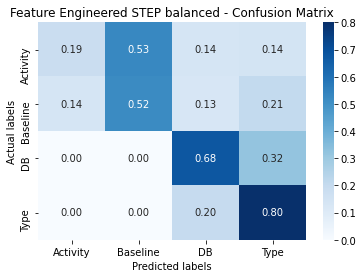

In [281]:
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le1.classes_, yticklabels = le1.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Feature Engineered STEP balanced - Confusion Matrix')
plt.savefig(f'20_figures/{model_name}_CF.png')

The **accuracy** score represents the proportion of correct classifications over all classifications.

The **F1 score** is a composite metric of two other metrics:

Specificity: proportion of correct 'positive predictions' over all 'positive' predictions.

Sensitivity: number of correct 'negative' predictions over all 'negative' predictions.

The F1 score gives insight as to whether all classes are predicted correctly at the same rate. A low F1 score and high accuracy can indicate that only a majority class is predicted.

In [282]:
a_s = accuracy_score(y_test, y_pred)
f1_s = f1_score(y_test, y_pred, average = 'weighted')

print(f'Accuracy Score: {a_s:.3f} \nF1 Score: {f1_s:.3f}')

Accuracy Score: 0.400 
F1 Score: 0.377
